<a href="https://colab.research.google.com/github/juniorliu95/NLP_practice/blob/main/natural-language-processing-applications/natural_language_inference_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.4 MB/s 


# Natural Language Inference: Fine-Tuning BERT
:label:`sec_natural-language-inference-bert`


In earlier sections of this chapter,
we have designed an attention-based architecture
(in :numref:`sec_natural-language-inference-attention`)
for the natural language inference task
on the SNLI dataset (as described in :numref:`sec_natural-language-inference-and-dataset`).
Now we revisit this task by fine-tuning BERT.
As discussed in :numref:`sec_finetuning-bert`,
natural language inference is a sequence-level text pair classification problem,
and fine-tuning BERT only requires an additional MLP-based architecture,
as illustrated in :numref:`fig_nlp-map-nli-bert`.

![This section feeds pretrained BERT to an MLP-based architecture for natural language inference.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/nlp-map-nli-bert.svg?raw=1)
:label:`fig_nlp-map-nli-bert`

In this section,
we will download a pretrained small version of BERT,
then fine-tune it
for natural language inference on the SNLI dataset.


In [2]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

## Loading Pretrained BERT

We have explained how to pretrain BERT on the WikiText-2 dataset in
:numref:`sec_bert-dataset` and :numref:`sec_bert-pretraining`
(note that the original BERT model is pretrained on much bigger corpora).
As discussed in :numref:`sec_bert-pretraining`,
the original BERT model has hundreds of millions of parameters.
In the following,
we provide two versions of pretrained BERT:
"bert.base" is about as big as the original BERT base model that requires a lot of computational resources to fine-tune,
while "bert.small" is a small version to facilitate demonstration.


In [3]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

Either pretrained BERT model contains a "vocab.json" file that defines the vocabulary set
and a "pretrained.params" file of the pretrained parameters.
We implement the following `load_pretrained_model` function to load pretrained BERT parameters.


In [4]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {
        token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # Load pretrained BERT parameters
    bert.load_state_dict(
        torch.load(os.path.join(data_dir, 'pretrained.params')))
    return bert, vocab

To facilitate demonstration on most of machines,
we will load and fine-tune the small version ("bert.small") of the pretrained BERT in this section.
In the exercise, we will show how to fine-tune the much larger "bert.base" to significantly improve the testing accuracy.


In [5]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model('bert.small', num_hiddens=256,
                                    ffn_num_hiddens=512, num_heads=4,
                                    num_layers=2, dropout=0.1, max_len=512,
                                    devices=devices)

![bert](https://miro.medium.com/max/700/0*ViwaI3Vvbnd-CJSQ.png)

## The Dataset for Fine-Tuning BERT

For the downstream task natural language inference on the SNLI dataset,
we define a customized dataset class `SNLIBERTDataset`.
In each example,
the premise and hypothesis form a pair of text sequence
and is packed into one BERT input sequence as depicted in :numref:`fig_bert-two-seqs`.
Recall :numref:`subsec_bert_input_rep` that segment IDs
are used to distinguish the premise and the hypothesis in a BERT input sequence.
With the predefined maximum length of a BERT input sequence (`max_len`),
the last token of the longer of the input text pair keeps getting removed until
`max_len` is met.
To accelerate generation of the SNLI dataset
for fine-tuning BERT,
we use 4 worker processes to generate training or testing examples in parallel.


In [6]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(*[
                d2l.tokenize([s.lower() for s in sentences])
                for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments,
                             dtype=torch.long), torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

After downloading the SNLI dataset,
we generate training and testing examples
by instantiating the `SNLIBERTDataset` class.
Such examples will be read in minibatches during training and testing
of natural language inference.


In [7]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                         num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                        num_workers=num_workers)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Fine-Tuning BERT

As the [schematic](https://www.notion.so/chapter-15-d5bc09be17f54c119c02fe775caa3a3d#43822a35c6a84b1f8cd1032bc8813609) for single text classification indicates,
fine-tuning BERT for natural language inference
requires only an **extra MLP** consisting of two fully-connected layers
(see `self.hidden` and `self.output` in the following `BERTClassifier` class).
This MLP **transforms the
BERT representation of the special “&lt;cls&gt;” token**,
which encodes the information of both the premise and the hypothesis,
into three outputs of natural language inference:
entailment, contradiction, and neutral.


In [8]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In the following,
the pretrained BERT model `bert` is fed into the `BERTClassifier` instance `net` for
the downstream application.
In common implementations of BERT fine-tuning,
only the parameters of the output layer of the additional MLP (`net.output`) will be learned from scratch.
All the parameters of the pretrained BERT encoder (`net.encoder`) and the hidden layer of the additional MLP (`net.hidden`) will be fine-tuned.


In [9]:
net = BERTClassifier(bert)

Recall that
in :numref:`sec_bert`
both the `MaskLM` class and the `NextSentencePred` class
have parameters in their employed MLPs.
These parameters are part of those in the pretrained BERT model
`bert`, and thus part of parameters in `net`.
However, such parameters are only for computing
the masked language modeling loss
and the next sentence prediction loss
during pretraining.
These two loss functions are irrelevant to fine-tuning downstream applications,
thus the parameters of the employed MLPs in 
`MaskLM` and `NextSentencePred` are not updated (staled) when BERT is fine-tuned.

To allow parameters with stale gradients,
the flag `ignore_stale_grad=True` is set in the `step` function of `d2l.train_batch_ch13`.
We use this function to train and evaluate the model `net` using the training set
(`train_iter`) and the testing set (`test_iter`) of SNLI.
Due to the limited computational resources, the training and testing accuracy
can be further improved: we leave its discussions in the exercises.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-3f20e13262cb>", line 4, in <module>
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
  File "/usr/local/lib/python3.7/dist-packages/d2l/torch.py", line 1590, in train_ch13
    devices)
  File "/usr/local/lib/python3.7/dist-packages/d2l/torch.py", line 1568, in train_batch_ch13
    l.sum().backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 149, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Tracebac

KeyboardInterrupt: ignored

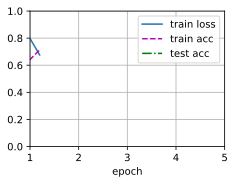

In [10]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## Summary

* We can fine-tune the pretrained BERT model for downstream applications, such as natural language inference on the SNLI dataset.
* During fine-tuning, the BERT model becomes part of the model for the downstream application. Parameters that are only related to pretraining loss will not be updated during fine-tuning. 


[Discussions](https://discuss.d2l.ai/t/1526)
